In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

from statsmodels.regression.linear_model import OLS

/Applications/anaconda3/envs/nilearn/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
process = 'components'
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/fmri'
data_dir = f'{top_dir}/input_data'
out_dir = f'{top_dir}/output_data'
figure_dir = f'{top_dir}/figures/{process}'
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

In [3]:
of = np.load(f'{out_dir}/of_activations/of_adelsonbergen.npy')
alexnet = np.load(f'{out_dir}/alexnet_activations/alexnet_conv2_avgframe.npy')
control = np.hstack([of, alexnet.T])

control = StandardScaler().fit_transform(control)
control_PCs = PCA(whiten=True, svd_solver='full', n_components=0.95).fit_transform(control)
print(control_PCs.shape)

(200, 167)


In [4]:
X = []
mask = np.load(f'{out_dir}/group_reliability/sub-all_reliability-mask.npy').astype('bool')
n_voxels = sum(mask)
for sid_ in range(4):
    sid = str(sid_+1).zfill(2)
    betas = np.load(f'{out_dir}/grouped_runs/sub-{sid}/sub-{sid}_train-data.npy')
    tot_voxels = betas.shape[0]

    #Filter the beta values to the reliable voxels
    betas = betas[mask, :]
    
    #Mean center the activation within subject
    offset_subject = betas.mean()
    betas -= offset_subject

    if type(X) is list:
        X = betas.T
    else:
        X = np.hstack([X, betas.T])
X_scaled = StandardScaler().fit_transform(X)

In [5]:
# n = X_scaled.shape[0]
# inds = np.zeros(n, dtype='bool')
# inds[:int(n*0.8)] = 1
# np.random.shuffle(inds)
# X_train = X_scaled[inds, :]
# X_test = X_scaled[~inds, :]

In [6]:
ols = LinearRegression(fit_intercept=False).fit(control_PCs, X_scaled)
residuals = X_scaled - ols.predict(control_PCs)

In [7]:
pca = PCA(whiten=True, svd_solver='full', n_components=0.8)
videos_by_comp = pca.fit_transform(residuals)
comp_by_voxels = pca.components_

avg = comp_by_voxels.reshape((-1, 4, n_voxels)).mean(axis=-2)

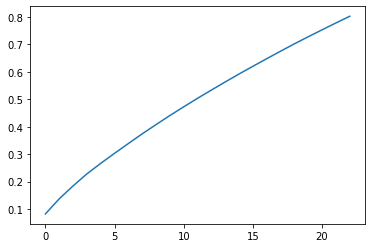

In [8]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [9]:
im = nib.load(f'{out_dir}/group_reliability/sub-all_stat-rho_statmap.nii.gz')
for i in range(avg.shape[0]):
    #Plot on the brain
    outname = f'{figure_dir}/PC{str(i+1).zfill(2)}.pdf'
    pc = np.zeros(tot_voxels)
    pc[mask] = avg[i, ...] * 1e3
    out_im = nib.Nifti1Image(pc.reshape(im.shape), affine=im.affine)
    plotting.plot_img_on_surf(out_im, inflate=True,
                              threshold=0.2,
                              output_file=outname,
                              views=['lateral', 'medial', 'ventral'])
    
#     # Look at response by stim
#     plt.bar(np.arange(0, 200), videos_by_comp[:, i])
#     plt.show()

In [10]:
df = pd.read_csv(f'{data_dir}/annotations/annotations.csv')
train = pd.read_csv(f'{data_dir}/annotations/train.csv')
df = df.merge(train)
df.sort_values(by=['video_name'], inplace=True)
features = df.columns.to_list()
features.remove('video_name')

In [11]:
d = pd.DataFrame()
for feature in features:
    for i in range(videos_by_comp.shape[-1]):
        pc = f'PC{i+1}'
        prod = np.dot(df[feature],videos_by_comp[:, i])
        d = d.append({'feature': feature, 'pc': pc,
                      'prod': prod},
                     ignore_index=True)

In [12]:
for i in range(videos_by_comp.shape[-1]):
    print(f'PC{i+1}')
    print(d[d.pc == f'PC{i+1}'].drop(columns=['pc']).sort_values(by='prod', ascending=False).reset_index(drop=True))
    print()

PC1
           feature      prod
0          arousal  5.623905
1     joint action  5.276427
2     transitivity  3.457563
3   agent distance  1.736412
4        dominance  1.720764
5          expanse  0.595995
6       facingness  0.314315
7           indoor -0.308018
8         intimacy -0.736752
9    communication -0.988611
10         valence -2.087094
11     cooperation -3.064877

PC2
           feature      prod
0           indoor  5.866957
1   agent distance  2.426845
2          arousal  1.507026
3       facingness  1.346084
4        dominance  0.730947
5    communication -0.248996
6      cooperation -1.076874
7     joint action -1.839567
8          valence -2.605092
9          expanse -2.783493
10        intimacy -6.675724
11    transitivity -7.163422

PC3
           feature      prod
0    communication  4.370466
1     joint action  4.277781
2       facingness  3.989970
3          valence  2.449328
4           indoor  1.359056
5      cooperation  1.220303
6         intimacy  0.790408
